# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt


# Preprocess data

In [10]:


from sklearn.preprocessing import StandardScaler
from scipy import stats

def preprocess_data(data_path, labels_path=None):
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c',
                'precipitation_amt_mm', 
                'week_start_date']
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
            
    df['station_avg_temp_c_mv_avg'] = df['station_avg_temp_c'].rolling(window=50).mean()
    features.append('station_avg_temp_c_mv_avg')
#     features.remove('station_avg_temp_c')
    
    df['precipitation_amt_mm_mv_avg'] = df['precipitation_amt_mm'].rolling(window=50).mean()
    features.append('precipitation_amt_mm_mv_avg')
#     features.remove('precipitation_amt_mm')
    
    df['reanalysis_specific_humidity_g_per_kg_avg'] = df['reanalysis_specific_humidity_g_per_kg'].rolling(window=5).mean()
    features.append('reanalysis_specific_humidity_g_per_kg_avg')
#     features.remove('reanalysis_specific_humidity_g_per_kg')
    
    df['reanalysis_dew_point_temp_k_avg'] = df['reanalysis_dew_point_temp_k'].rolling(window=10).mean()
    features.append('reanalysis_dew_point_temp_k_avg')
#     features.remove('reanalysis_dew_point_temp_k')
    
    
    df.fillna(method='ffill', inplace=True)
    df = df.fillna(df.mean())
    
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    for i in range(1,5):
        df['quarter_' + str(i)] = df['week_start_date'].apply(lambda date: 1 if (
            ((i-1)*3<date.to_datetime().month) and (date.to_datetime().month <= i * 3)) else 0)
        features.append('quarter_' + str(i))
    
    df = df.drop(['week_start_date'], axis=1)
    features.remove('week_start_date')
    df = df[features]    
    sj_label = None
    iq_label = None
    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2]).loc[df.index]
        sj_label = pd.DataFrame(labels.loc['sj'])
        iq_label = pd.DataFrame(labels.loc['iq'])

    sj = pd.DataFrame(df.loc['sj'])
    iq = pd.DataFrame(df.loc['iq'])
    
    
    return sj, iq, sj_label, iq_label

In [11]:
sj_train, iq_train, sj_label, iq_label = preprocess_data('./data/train_features.csv', './data/train_labels.csv')
sj_train.head()

/usr/local/lib/python3.5/dist-packages/pandas/core/series.py:2551: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  mapped = lib.map_infer(values, f, convert=convert_dtype)


reanalysis_specific_humidity_g_per_kg  \
year weekofyear                                          
1990 18                                      14.012857   
     19                                      15.372857   
     20                                      16.848571   
     21                                      16.672857   
     22                                      17.210000   

                 reanalysis_dew_point_temp_k  station_avg_temp_c  \
year weekofyear                                                    
1990 18                           292.414286           25.442857   
     19                           293.951429           26.714286   
     20                           295.434286           26.714286   
     21                           295.310000           27.471429   
     22                           295.821429           28.942857   

                 precipitation_amt_mm  station_avg_temp_c_mv_avg  \
year weekofyear                                                    
1990 18                         12.42                  27.041766   
     19                         22.82                  27.041766   
     20                         34.54                  27.041766   
     21                         15.36                  27.041766   
     22                          7.52                  27.041766   

                 precipitation_amt_mm_mv_avg  \
year weekofyear                                
1990 18                            44.730679   
     19                            44.730679   
     20                            44.730679   
     21                            44.730679   
     22                            44.730679   

                 reanalysis_specific_humidity_g_per_kg_avg  \
year weekofyear                                              
1990 18                                          16.763206   
     19                                          16.763206   
     20                                          16.763206   
     21                                          16.763206   
     22                                          16.023429   

                 reanalysis_dew_point_temp_k_avg  quarter_1  quarter_2  \
year weekofyear                                                          
1990 18                               295.297951          0          1   
     19                               295.297951          0          1   
     20                               295.297951          0          1   
     21                               295.297951          0          1   
     22                               295.297951          0          1   

                 quarter_3  quarter_4  
year weekofyear                        
1990 18                  0          0  
     19                  0          0  
     20                  0          0  
     21                  0          0  
     22                  0          0

# Split validation and training

In [12]:
from sklearn.model_selection import train_test_split

# split data into training and validation data, for both predictors and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.

# sj_train.head()

sj_train_X, sj_test_X, sj_train_y, sj_test_y = train_test_split(sj_train, sj_label['total_cases'], test_size=0.1, random_state=0, shuffle=False)

iq_train_X, iq_test_X, iq_train_y, iq_test_y = train_test_split(iq_train, iq_label['total_cases'], test_size=0.25, random_state=0, shuffle=False)

# Train Model

In [15]:
sj_model = RandomForestRegressor(n_estimators=200, max_depth=6,
                                 criterion='mae', warm_start=True)

sj_model.fit(sj_train_X, sj_train_y)
sj_pred_val = sj_model.predict(sj_test_X)

print("SJ " + str(mean_absolute_error(sj_test_y, sj_pred_val)))

iq_model = RandomForestRegressor(n_estimators=20, max_features='auto',
                                 max_depth=6, min_samples_leaf=0.005,
                                 criterion='mae', min_weight_fraction_leaf=0.1
                                , warm_start=True)

iq_model.fit(iq_train_X, iq_train_y)
iq_pred_val = iq_model.predict(iq_test_X)

print("IQ " + str(mean_absolute_error(iq_test_y, iq_pred_val)))


SJ 13.61228723404255
IQ 7.792307692307692


# Plot predictions

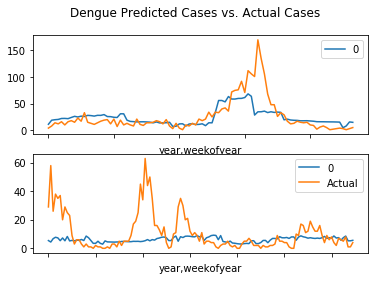

In [16]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
pd.DataFrame(sj_pred_val).plot(ax=axes[0], label="Predictions")
sj_test_y.plot(ax=axes[0], label="Actual")

# plot iq
pd.DataFrame(iq_pred_val).plot(ax=axes[1], label="Predictions")
iq_test_y.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

# Save predictions

In [19]:

sj_test, iq_test, sj_test_label, iq_test_label = preprocess_data('./data/dengue_features_test.csv')

sj_predictions = sj_model.predict(sj_test).astype(int)
iq_predictions = iq_model.predict(iq_test).astype(int)

submission = pd.read_csv("./data/submission .csv", index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])

submission.to_csv("./results/new_submission1.csv")

/usr/local/lib/python3.5/dist-packages/pandas/core/series.py:2551: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  mapped = lib.map_infer(values, f, convert=convert_dtype)


# Compare benchmarks

Comparison : MAE : 19.120192307692307


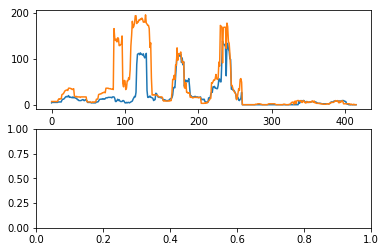

In [20]:
benchmark = pd.read_csv('./results/best.csv')
submission = pd.read_csv('./results/new_submission1.csv')


# adder = lambda x: x + 10
# formated_total_cases = submission['total_cases'].apply(adder)

# print(formated_total_cases)

figs, axes = plt.subplots(nrows=2, ncols=1)

# # submission = submission.iloc[50:]
# plot sj
benchmark.total_cases.plot(ax=axes[0], label="Actual")
submission.total_cases.plot(ax=axes[0], label="Predictions")
    

# plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
# plt.legend()

# plt.show()

print("Comparison : MAE : " + str(mean_absolute_error(benchmark.total_cases, submission.total_cases)))